# Imports

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('fivethirtyeight')

#print(plt.rcParams)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['figure.facecolor'] = 'w'
#plt.rcParams['grid.linestyle'] = 'dashed'
#plt.rcParams['font.size'] = 20
#plt.rcParams['axes.edgecolor'] = '#afafaf'
#plt.rcParams['grid.color'] = '#afafaf'
#plt.rcParams['axes.facecolor'] = '#fafafa'
#plt.rcParams['axes.facecolor'] = 'w'
#plt.rcParams['figure.facecolor'] = '#fafafa'
#plt.rcParams['figure.facecolor'] = 'w'

In [10]:
import astropy
import astropy.coordinates as coord
import astropy.units as ufrom pandas import Series, DataFrame

import astropy.constants as c
from astropy.table import Table

# Zwicky catalog of galaxies

In [ ]:
uzcat = pd.read_table('data/uzcJ2000.tab/uzcJ2000.tab', 
                   sep='\t', 
                   header=16, 
                   dtype='str',
                   names=['ra', 'dec', 'Zmag', 'cz', 'cze', 'T', 'U', 'Ne',
                           'Zname', 'C', 'Ref', 'Oname', 'M', 'N'],
                   skiprows=[17])

In [ ]:
uzcat.head()

In [ ]:
uzcat['ra'] = uzcat['ra'].apply(lambda x: '{0}h{1}m{2}s'.format(x[:2],x[2:4],x[4:]))
uzcat['dec'] = uzcat['dec'].apply(lambda x: '{0}d{1}m{2}s'.format(x[:3],x[3:5],x[5:]))

In [ ]:
coords_uzc = coord.SkyCoord(uzcat['ra'], uzcat['dec'], frame='fk5', equinox='J2000')

In [ ]:
coords_uzc.ra.deg.min()

In [ ]:
uzcat = uzcat.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
uzcat['cz'] = uzcat['cz'].astype('float')

In [ ]:
color_czs = (uzcat['cz']+abs(uzcat['cz'].min())) / (uzcat['cz'].max()+abs(uzcat['cz'].min()))

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(coords_uzc.ra.radian-np.pi, coords_uzc.dec.radian, 
           color=plt.cm.Blues_r(color_czs), alpha=0.7,
           s=4, marker='.', zorder=-1);

In [ ]:
uzc_czs = uzcat['cz'].as_matrix()
uzcat['Zmag'] = uzcat['Zmag'].astype('float')
decmin = 15
decmax = 30
ramin = 90
ramax = 295
czmin = 0
czmax = 12500
selection_dec = (coords_uzc.dec.deg>decmin) * (coords_uzc.dec.deg<decmax)
selection_ra = (coords_uzc.ra.deg>ramin) * (coords_uzc.ra.deg<ramax)
selection_czs = (uzc_czs>czmin) * (uzc_czs<czmax)
selection= selection_dec * selection_ra * selection_czs

In [ ]:
fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
sct = ax.scatter(coords_uzc.ra.radian[selection_dec], uzc_czs[selection_dec], 
                     color='SteelBlue',
                     #color=plt.cm.RdBu((coords_uzc.dec.deg[selection])/100.), 
                     s=uzcat['Zmag'][selection_dec*selection_czs], 
                     edgecolors="none", 
                     alpha=0.7,
                    zorder=0)
ax.set_rlim(0,20000)
ax.set_theta_offset(np.pi/-2)
ax.set_rlabel_position(65)
ax.set_rticks(range(2500,20001,5000));
ax.plot([(ramin*u.deg).to(u.radian).value, (ramin*u.deg).to(u.radian).value], [0,12500], 
        color='IndianRed', alpha=0.8, dashes=(10,4))
ax.plot([ramax*np.pi/180., ramax*np.pi/180.], [0,12500],
        color='IndianRed', alpha=0.8, dashes=(10,4))
theta = np.arange(ramin, ramax, 1)
ax.plot(theta*np.pi/180., np.ones_like(theta)*12500,
        color='IndianRed', alpha=0.8, dashes=(10,4));

In [ ]:
mycat = uzcat.copy(deep=True).loc[selection]
mycat['ra_deg'] = coords_uzc.ra.deg[selection]
mycat['dec_deg'] = coords_uzc.dec.deg[selection]

In [ ]:
mycat.Zmag = mycat.Zmag.astype('float')
mycat.Zmag.head()


In [ ]:
zs = (((mycat['cz'].as_matrix()*u.km/u.s) / c.c).decompose())
dist = coord.Distance(z=zs)
print(dist)
mycat['dist'] = dist

In [ ]:
coords_xyz = coord.SkyCoord(ra=mycat['ra_deg']*u.deg, dec=mycat['dec_deg']*u.deg, distance=dist*u.Mpc, frame='fk5', equinox='J2000')

In [ ]:
mycat['X'] = coords_xyz.cartesian.x.value
mycat['Y'] = coords_xyz.cartesian.y.value
mycat['Z'] = coords_xyz.cartesian.z.value

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(14,6))

plt.subplot(121)
plt.scatter(mycat['Y'], -1*mycat['X'], s=8, color=plt.cm.OrRd_r(10**(mycat.Zmag-mycat.Zmag.max()) ), edgecolor='None')
plt.xlabel('Y (Mpc)'); plt.ylabel('X (Mpc)')
plt.axis('equal');

#plt.figure(figsize=(7,6))
plt.subplot(122)
plt.scatter(-1*mycat['X'],mycat['Z'], s=8, color=plt.cm.OrRd_r(10**(mycat.Zmag-mycat.Zmag.max()) ), edgecolor='None')
lstyle = dict(lw=1.5, color='k', dashes=(6,4))
plt.plot([0,150], [0,80], **lstyle)
plt.plot([0,150], [0,45], **lstyle)
plt.plot([0,-25], [0,80], **lstyle)
plt.plot([0,-25], [0,45], **lstyle)
plt.xlabel('X (Mpc)'); plt.ylabel('Z (Mpc)')
plt.axis('equal');

In [ ]:
mycat.describe()

Can we plot something like this??

<img src="http://i.huffpost.com/gen/2023548/thumbs/o-LANIAKEA-MAP-900.jpg?1">

# Map of the Milky Way

http://bessel.vlbi-astrometry.org/parallax


#### Format of input file
|name | l |	b | Prlx | err | $\mu_\alpha$ cos ($\delta$) |err| $\mu_\delta$ | err | v_LSR | err  | Freq | Telescope | Ref | 
|--|--|	-- | -- | -- | -- | -- | -- | --| --| --| -- | -- | 
| [str] | [deg] | [deg] | [mas] | +/- | [mas/yr] | +/- | [mas/yr] | +/- | [km/s] | +/- | [GHz] | [str] | [str] | 
| G105.41+09.87 | 105.41 | 9.87 | 1.129 | 0.063 | -0.21 | 2.38 | -5.49 | 2.38 | -10.0 | 5.0 | 22.2 | VLBA | 2013ApJ...769...15X |

### Read the data

In [ ]:
uzcat = pd.read_table('data/bessel.tab',  
                   delim_whitespace=True,
                   names=['name', 'l', 'b', 'prlx', 'prlxerr', 'mua', 'muaerr', 
                          'mud', 'muderr', 'vlsr', 'vlsrerr', 'freq', 'telescope', 'ref'],
                     )

In [ ]:
uzcat.head()

### Convert to Astropy Table

In [ ]:
uzcat = Table(data=uzcat.as_matrix(),                    
    names=['name', 'l', 'b', 'prlx', 'prlxerr', 'mua', 'muaerr', 
                          'mud', 'muderr', 'vlsr', 'vlsrerr', 'freq', 'telescope', 'ref'],
    dtype=[str, float, float, float, float, float, float, 
                          float, float,float, float, str, str, str],
     )

In [ ]:
uzcat

In [ ]:
uzcat['l'].unit = u.deg
uzcat['b'].unit = u.deg
uzcat['prlx'].unit = u.mas
uzcat['prlxerr'].unit = u.mas
uzcat['mua'].unit = u.mas/u.year
uzcat['muaerr'].unit = u.mas/u.year
uzcat['mud'].unit = u.mas/u.year
uzcat['muderr'].unit = u.mas/u.year
uzcat['vlsr'].unit = u.km/u.s
uzcat['vlsrerr'].unit = u.km/u.s
uzcat['freq'].unit = u.GHz

In [ ]:
uzcat['mud'].unit

In [ ]:
uzcat['l'][:5]

### Plot the data

In [ ]:
distances = 1./uzcat['prlx'].quantity.to(u.arcsec).value * 1e-3

In [ ]:
fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
sct = ax.scatter(uzcat['l'].quantity.to(u.rad), distances, 
                     color='IndianRed',
                     #color=plt.cm.RdBu((coords_uzc.dec.deg[selection])/100.), 
                     #s=uzcat['Zmag'][selection_dec*selection_czs], 
                     edgecolors="none",
                    zorder=0)
gc = ax.plot(0,8.4, 'x', ms=10, mew=3, c='Green')
ax.text(0,8.9, 'Galactic Center')
ax.set_rlim(0,10)
ax.set_theta_offset(np.pi/2)
ax.set_rlabel_position(180)
ax.set_rticks(range(2,16,2));
#ax.plot([(ramin*u.deg).to(u.radian).value, (ramin*u.deg).to(u.radian).value], [0,12500], 
#        color='IndianRed', alpha=0.8, dashes=(10,4))
#ax.plot([ramax*np.pi/180., ramax*np.pi/180.], [0,12500],
#        color='IndianRed', alpha=0.8, dashes=(10,4))
#theta = np.arange(ramin, ramax, 1)
#ax.plot(theta*np.pi/180., np.ones_like(theta)*12500,
#        color='IndianRed', alpha=0.8, dashes=(10,4));

# Equatorial and Galactic Coordinates

## Popular packages

    -WCSAxes
    http://wcsaxes.readthedocs.org/

    -PyWCSGrid2
    http://leejjoon.github.io/pywcsgrid2/
    
    - APLpy
    https://aplpy.github.io/
    


### PyWCSGrid2


### APLpy




### WCSAxes
Intended as a replacement for both APLpy, PyWCSGrid2

In [11]:
from astropy.wcs import WCS
from wcsaxes import datasets

#hdu = datasets.fetch_l1448_co_hdu()
hdu = datasets.fetch_msx_hdu()

wcs = WCS(hdu.header)
#hdu.writeto('data/l1558_13co.fits')
try:
    hdu.writeto('data/msx.fits')
except:
    pass

In [12]:
from astropy.io import fits

#hdu = fits.open('data/l1558_13co.fits')[0]

hdu = fits.open('data/msx.fits')[0]
wcs = WCS(hdu.header)

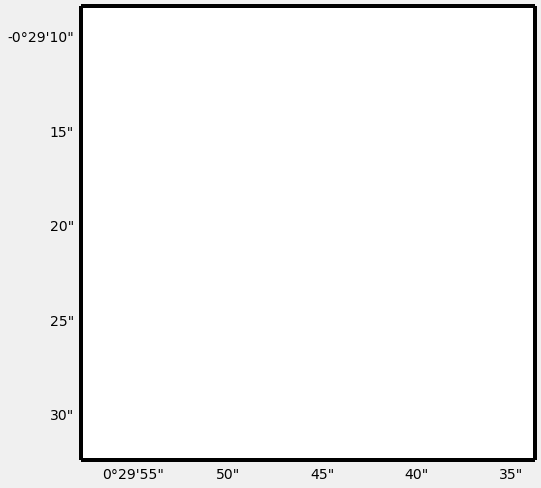

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9], projection=wcs)

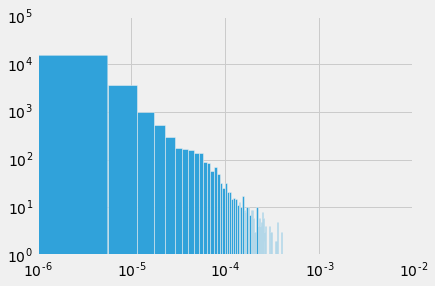

In [14]:
plt.hist(hdu.data.flatten(),bins=500)
plt.yscale('log')
plt.xscale('log')

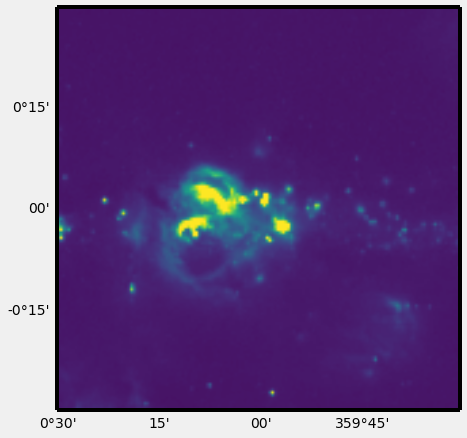

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)
ax.imshow(hdu.data, vmin=-1.e-5, vmax=2.e-4, cmap=plt.cm.viridis,
          origin='lower')

# Other